In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [2]:
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 0.5
v = 0
delta_u = 1.
mu_M = 0.00001
mu_Q = 0.00001
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [3]:
num_visible = 30
num_hidden = 30
num_neurons = num_visible + num_hidden
num_timebins = 1000

weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M, 0)

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_Q, 0)

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])



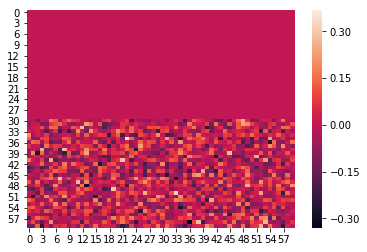

In [4]:
sns.heatmap(weights_Q)

In [5]:

for tt in range(1, num_timebins):
        
#     for ii in range(num_neurons):
        
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta
    
#     if tt % 100 < 5:
#         phi[:, tt] += 0.5

    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

In [6]:
gaussian_intervals = np.random.normal(size = 100, loc=30, scale=10).astype(int)

In [7]:
## staircase pattern
neuron_block_size = np.floor(num_visible / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

    
for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 10.0
    nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    rho[nonblock_idx, tt] = 0.05


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

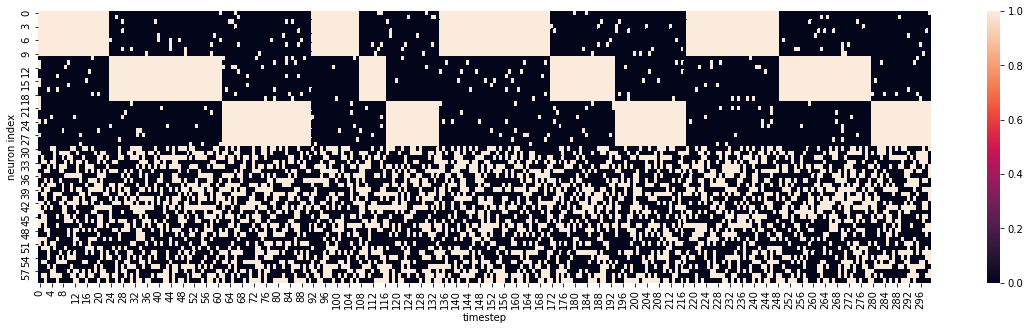

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(spikes[:, :300])
plt.xlabel("timestep")
plt.ylabel("neuron index")

In [9]:
import autograd.numpy as np

In [10]:
learned_weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_M, 0)

learned_weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_Q, 0)

free_energy_trace = []
LL_M_trace = []
LL_Q_trace = []
iter_num = 0

In [11]:
## Simulate t = 1,...,T for Q network to get hidden neurons' spikes


for iter_num in range(300):
    
    phi_Q = phi #np.zeros(shape = (num_neurons, num_timebins))
    rho_Q = rho #np.zeros(shape = (num_neurons, num_timebins))
    eta_Q = eta #np.zeros(shape = (num_neurons, num_timebins))
    u_Q = u #np.zeros(shape = (num_neurons, num_timebins))
    spikes_Q = np.zeros(shape = (num_neurons, num_timebins))
    spike_probs_Q = np.zeros(shape = (num_neurons, num_timebins))

#     phi_Q = phi
#     eta_Q[:, 0] = np.zeros(num_neurons)
#     u_Q[:, 0] = np.matmul(weights_Q, phi_Q[:, 0]) - eta_Q[:, 0]
#     rho_Q[:, 0] = rho_0 * np.exp(u_Q[:, 0])
    spike_probs_Q[:, 0] = 1-np.exp(-rho_Q[:, 0])
    spikes_Q[:, 0] = np.random.binomial(n = 1, p = spike_probs_Q[:, 0])
    spikes_Q[:num_visible, :] = spikes[:num_visible, :]
    
    for tt in range(1, num_timebins):

#         for ii in range(num_neurons):

        dphi = dt * (1 / tau) * (spikes_Q[:, tt - 1] - phi_Q[:, tt - 1])
        deta = dt * (1 / tau_adapt) * (spikes_Q[:, tt - 1] - eta_Q[:, tt - 1])

        phi_Q[:, tt] = phi_Q[:, tt - 1] + dphi
        eta_Q[:, tt] = eta_Q[:, tt - 1] + deta

        total_potential = np.matmul(learned_weights_Q, phi_Q[:, tt]) - eta_0 * eta_Q[:, tt]
        u_Q[:, tt] = total_potential

        rho_Q[:, tt] = rho_0 * np.exp((u_Q[:, tt] - v) / delta_u)

        spike_probs_Q[:, tt] = 1-np.exp(-dt*rho_Q[:, tt])
        spikes_Q[:, tt] = np.random.binomial(n = 1, p = spike_probs_Q[:, tt])
        spikes_Q[:num_visible, :] = spikes[:num_visible, :]



    ## Set hidden spikes to be those just simulated from Q network
    spikes[num_visible:, :] = spikes_Q[num_visible:, :]


    ## Calculate likelihood of M network

    def LL_M(curr_weights):
        total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

        curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
        LL = np.sum(np.multiply(np.log(rho), spikes) - curr_rho) * dt
        return LL



    ## Take gradient of M network LL wrt M weights and update M weights

    curr_LL_M = LL_M(learned_weights_M)
    grad_LL_M = grad(LL_M)
    M_weights_gradients = grad_LL_M(learned_weights_M)

    learned_weights_M += mu_M * M_weights_gradients


    ## Calculate likelihood of Q network (only sums over hidden neurons)

    def LL_Q(curr_weights):
        total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

        curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
        individual_likelihoods = np.multiply(np.log(curr_rho), spikes_Q) - curr_rho
        LL = np.sum(individual_likelihoods[num_visible:, :]) * dt # only sum over hidden
        return LL



    ## Calculate point estimate of free energy

    curr_LL_Q = LL_Q(learned_weights_Q)
    free_energy = curr_LL_Q - curr_LL_M
    free_energy_trace.append(free_energy)


    ## Take gradient wrt Q network LL, multiply by free energy, and update Q weights
    ## Set connections toward visible neurons to 0

    grad_LL_Q = grad(LL_Q)
    Q_weights_gradients = grad_LL_Q(learned_weights_Q)

    if iter_num == 0:
        curr_free_energy = 1
    else:
        curr_free_energy = free_energy - np.mean(free_energy_trace)
    
#     mu_Q = 1e-10
    learned_weights_Q += mu_Q * Q_weights_gradients
    learned_weights_Q[:num_visible, :] = 0

    LL_M_trace.append(curr_LL_M)
    LL_Q_trace.append(curr_LL_Q)

    if iter_num % 20 == 0:
        print 'iter: {}, M: {}, Q: {}'.format(iter_num, curr_LL_M, curr_LL_Q)


iter: 0, M: -47337.7112591, Q: -22672.137376
iter: 20, M: -33822.9676911, Q: -21378.3113969
iter: 40, M: -29510.0681786, Q: -20463.697306
iter: 60, M: -27291.4387802, Q: -19812.8113785
iter: 80, M: -25922.8029724, Q: -19306.7500564
iter: 100, M: -25050.6726454, Q: -19020.2675372
iter: 120, M: -24137.9338713, Q: -18411.0923368
iter: 140, M: -23476.5393184, Q: -18019.5265576
iter: 160, M: -22888.7172151, Q: -17583.1722289
iter: 180, M: -22576.3804586, Q: -17414.7699016
iter: 200, M: -22129.7244439, Q: -17047.4145004
iter: 220, M: -21893.80734, Q: -16867.9015732
iter: 240, M: -21522.8216593, Q: -16532.4479279
iter: 260, M: -21207.467302, Q: -16232.4076791
iter: 280, M: -21172.0003346, Q: -16254.0371916


In [12]:
Q_weights_gradients

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.3863991 , -13.13206218, -12.67264   , ...,  -8.04450696,
         -9.48239467,  -6.04921621],
       [-13.9677892 , -13.49650948, -14.9485003 , ...,  -8.83182878,
         -8.36440507,  -9.68278409],
       [-17.14882152, -16.97141982, -17.02793611, ...,  -7.36701977,
         -7.10900886,  -9.37973841]])

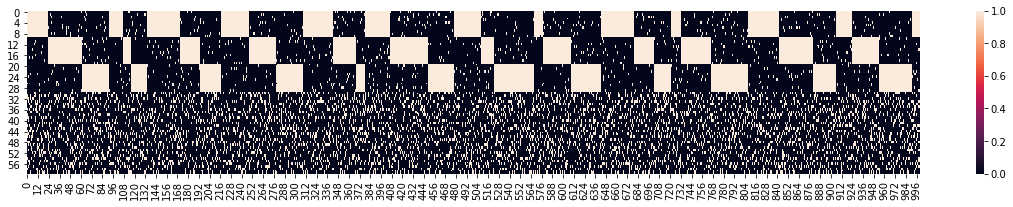

In [13]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_Q)

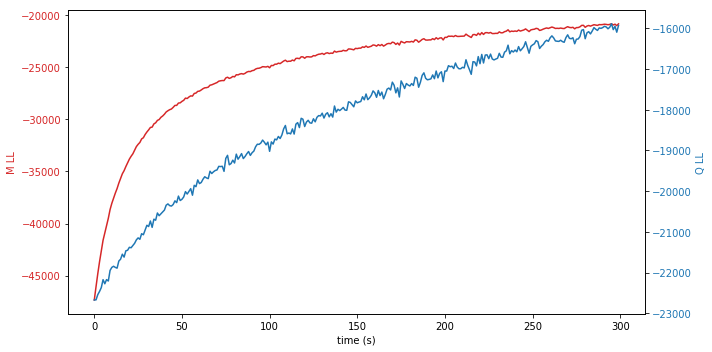

In [14]:
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('M LL', color=color)
ax1.plot(LL_M_trace, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Q LL', color=color)  # we already handled the x-label with ax1
ax2.plot(LL_Q_trace, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [15]:
print np.sum((learned_weights_M[:num_visible, :num_visible] - weights_M[:num_visible, :num_visible])**2)

33.33300075196713


In [16]:
curr_neuron_block = 0
spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

for tt in range(1, num_timebins):
        
        
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

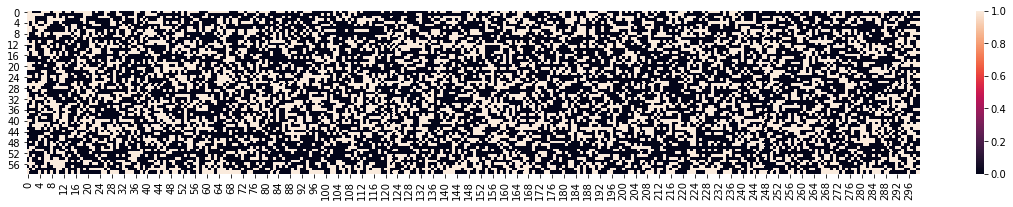

In [17]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :300])